## Betting Algorithm

### Introduction
The goal of this notebook is to develop a algorithm based off a match predicting model. In this notebook, the model of choice ix xgb_v1, and compatible datasets for training and backtesting are selected.

Given two players and match context, the model is able to produce an expectation that a player is going to win. The underlying algorithm calculates fair odds for betting. If there is enough margin, the algorithm bets.

### Data

In [94]:
import numpy as np
import pandas as pd

def get_data():
    train_df = pd.read_parquet("../../data/training_data/dataset_v1.parquet")
    backtest_df = pd.read_parquet("../../data/backtest/backtest_v1.parquet")

    return train_df, backtest_df

train_df, backtest_df = get_data()


The model will be trained with data from `training_data\dataset_v1.parquet` until some specified time. The backtest will run from when the training period ends.

In [95]:
train_end_date = 20231231

train_df = train_df[train_df["tourney_date"] <= train_end_date]
backtest_df = backtest_df[backtest_df["tourney_date"] > train_end_date]

### Model
The model is imported and trained with data until end of 2005.

In [ ]:
import pickle

def get_trained_model(train_df):
    with open("../../models/xgb_v1.pkl", "rb") as f:
        model = pickle.load(f)

    X = train_df.drop(columns=["result"])
    y = train_df["result"]

    model.fit(X, y)

    return model

model_xgb_v1 = get_trained_model(train_df)


### Base Algorithm

The most basic algorithm takes in a predicted probability of winning and odds. The algorithm will then trade if it finds a large enough margin. It also bets a fixed amount every match.

The predicted probabilities are precomputed to utilise xgboost's parallel processing.


In [ ]:
feature_cols = train_df.columns.drop(["result"])

# precompute predicted probabilities
X = backtest_df[feature_cols]
probs_a = model_xgb_v1.predict_proba(X)[:, 1]
backtest_df = backtest_df.copy()
backtest_df["prob_a_xgb_v1"] = probs_a

def basic_algorithm(row, odds_a, odds_b, margin=0):
    """
    Basic algorithm that bets a fixed amount every match. Returns positive if betting on A, negative if betting on B.
    """
    prob_a = row["prob_a_xgb_v1"]
    fair_odds_a = 1 / prob_a
    fair_odds_b = 1 / (1 - prob_a)

    bet_size = 100  
    if odds_a > fair_odds_a + margin:
        return bet_size
    elif odds_b > fair_odds_b + margin:
        return -bet_size

    return 0

### Backtest Engine

The backtester expects a betting algorithm, and reads the odds and keeps track of a balance. Commission is optional, and is only applied to winnings. 

The backtester returns a list of the balances over each bet.

In [ ]:
def get_odds(row):
    # find odds, use b365 if available, otherwise use ps
    if pd.notna(row["B365W"]) and pd.notna(row["B365L"]):
        odds_w = row["B365W"]
        odds_l = row["B365L"]
    elif pd.notna(row["PSW"]) and pd.notna(row["PSL"]):
        odds_w = row["PSW"]
        odds_l = row["PSL"]
    else:
        return None, None
    
    result = row["result"]
    if result == 1:
        odds_a = odds_w
        odds_b = odds_l
    else:
        odds_a = odds_l
        odds_b = odds_w
    
    return odds_a, odds_b

def backtester(backtest_df, algorithm, starting_balance=2000, commission=0):
    balance = starting_balance
    balance_history = [balance]
    return_history = []

    for index, row in backtest_df.iterrows():
        
        odds_a, odds_b = get_odds(row)
        if odds_a is None:
            continue
        
        bet = algorithm(row, odds_a, odds_b)

        result = row["result"]

        if bet is None or pd.isna(bet) or bet == 0:
            balance_history.append(balance)
            return_history.append(0)
            continue

        stake = abs(bet)
        
        if (bet > 0 and result == 1) or (bet < 0 and result == 0):
            # Win
            odds = odds_a if bet > 0 else odds_b
            gross_profit = stake * (odds - 1)

            # apply commission only on winnings
            net_profit = gross_profit * (1 - commission)
            balance += net_profit
            return_history.append(net_profit)
        else:
            # Loss
            balance -= stake
            return_history.append(-stake)

        balance_history.append(balance)

    return balance_history, return_history


### Running the Backtester

We first run the backtester on the base algorithm.

In [ ]:
balance_history, return_history = backtester(backtest_df, basic_algorithm, commission=0.02)

Visualising the results:

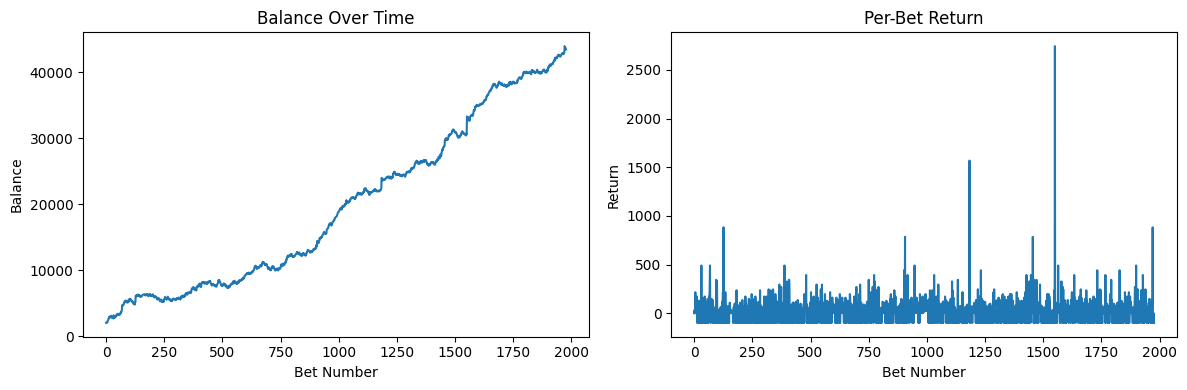

Total profit: 41489.16000000007
Total bets: 1977
Win rate: 0.5624683864441072
Average return: 20.98591805766316
Max return: 2744.0
Min return: -100


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: balance over time
axes[0].plot(balance_history)
axes[0].set_xlabel("Bet Number")
axes[0].set_ylabel("Balance")
axes[0].set_title("Balance Over Time")

# Right: per-bet returns
axes[1].plot(return_history)
axes[1].set_xlabel("Bet Number")
axes[1].set_ylabel("Return")
axes[1].set_title("Per-Bet Return")

plt.tight_layout()
plt.show()

# print statistics
print(f"Total profit: {sum(return_history)}")
print(f"Total bets: {len(return_history)}")
print(f"Win rate: {np.sum(np.array(return_history) > 0) / len(return_history)}")
print(f"Average return: {sum(return_history) / len(return_history)}")
print(f"Max return: {max(return_history)}")
print(f"Min return: {min(return_history)}")